In [1]:
from importlib import reload
import os
# import re
# import numpy as np
# import pandas as pd

import yfinance as yf

os.chdir('idle')
import shuhua
import soyeon
import yuqi
import minnie
import miyeon
import soojin

In [2]:
%%time
reload(minnie)

tick = 'FL'

inc = minnie.macro_scrape(tick,'income-statement')
bal = minnie.macro_scrape(tick,'balance-sheet')
cash = minnie.macro_scrape(tick,'cash-flow-statement')
rats = minnie.macro_scrape(tick,'financial-ratios')
results = yuqi.calc_ratios(tick,rats,0,7)
results

HTTPError (Probably 403 Access Denied). Trying again with User-Agent set to Mozilla
HTTPError (Probably 403 Access Denied). Trying again with User-Agent set to Mozilla
HTTPError (Probably 403 Access Denied). Trying again with User-Agent set to Mozilla
HTTPError (Probably 403 Access Denied). Trying again with User-Agent set to Mozilla
I believe Receiveable Turnover in FL is completely blank for this date range
CPU times: total: 281 ms
Wall time: 1.09 s


['FL',
 16.941,
 -0.885,
 9.425,
 -1.457,
 18.115,
 -0.702,
 1.509,
 -0.196,
 4.423,
 0.057,
 nan,
 0,
 0.062,
 0.012,
 0.073,
 0.016]

In [3]:
%%time

t='FL'
stocky = yf.Ticker(t)

###4 API Calls, 2.01s###
info = stocky.info
inc = stocky.financials.fillna(0)
bal = stocky.balance_sheet.fillna(0)
cash = stocky.cashflow.fillna(0)

CPU times: total: 219 ms
Wall time: 1.17 s


In [4]:
cap = info['marketCap']
price = info['currentPrice']
shares = info['sharesOutstanding']
PE = info['trailingPE']
# growth = info['earningsGrowth'] #No longer in api call

# def pull_long():
###INCOME###
rev = inc.loc['Total Revenue'][::-1]
netinc = inc.loc['Net Income'][::-1]
###BALANCE###
lia = bal.loc['Total Liabilities Net Minority Interest'][::-1]
ass = bal.loc['Total Assets'][::-1]
Clia = bal.loc['Current Liabilities'][::-1]
Cass = bal.loc['Total Assets'][::-1]
try:
    deb = bal.loc['Long Term Debt'][::-1] + bal.loc['Short Long Term Debt'][::-1]
    deb.name = 'Total Debt'
except KeyError:
    deb = bal.loc['Long Term Debt'][::-1]

#Include Long Term Capital Lease Obligations LATER
equ = bal.loc['Stockholders Equity'][::-1]
###CASH###
try:
    fcf = cash.loc['Total Cash From Operating Activities'][::-1] + cash.loc['Capital Expenditures'][::-1]
    fcf.name = 'Free Cash Flow'
except KeyError:
    fcf = cash.loc['Free Cash Flow'][::-1]
# def calc_met():
###CALC###
inv = equ+deb
roa = netinc/ass
roa.name = 'Return on Asset'
roe = netinc/equ
roe.name = 'Return on Equity'
roi = netinc/inv
roi.name = 'Return on Invested Capital'
Aass=[]
for i in range(len(ass)):
    if i == len(ass)-1:
        Aass.append(ass[i])
    else:
        Aass.append((ass[i]+ass[i+1])/2)
ATO = rev/Aass
ATO.name = 'Asset Turnover'
DE = deb/equ
DE.name = 'Debt to Equity'
DA = deb/ass
DA.name = 'Debt to Asset'
DC = deb/(equ+deb)
DC.name = 'Debt to Invested Capital'

<BarContainer object of 4 artists>

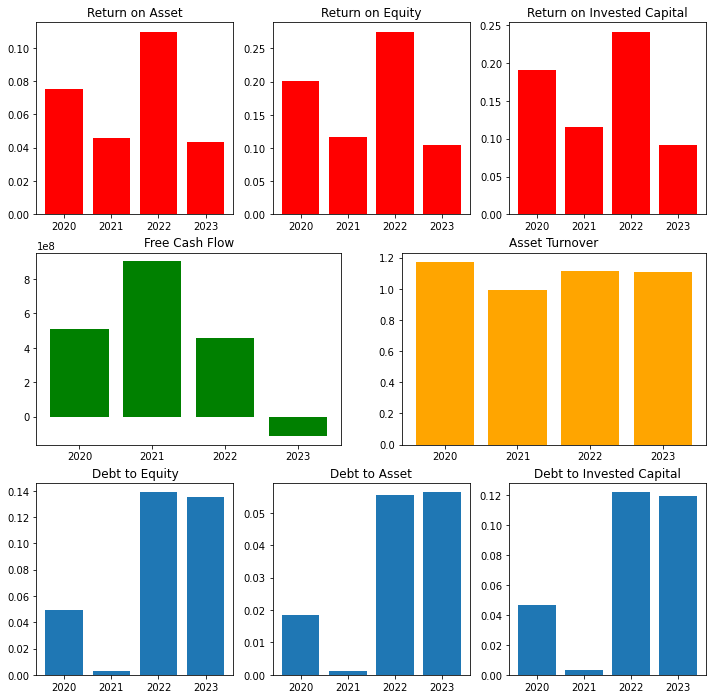

In [5]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(12,12))
ax1 = plt.subplot(3,3,1)
ax2 = plt.subplot(3,3,2)
ax3 = plt.subplot(3,3,3)
ax4 = plt.subplot(3,2,3)
ax5 = plt.subplot(3,2,4)
#ax6 = plt.subplot(3,3,6)
ax7 = plt.subplot(3,3,7)
ax8 = plt.subplot(3,3,8)
ax9 = plt.subplot(3,3,9)
prof = [[ax1,roa],[ax2,roe],[ax3,roi]]
risk = [[ax7,DE],[ax8,DA],[ax9,DC]]

for p in prof:
    years=[]
    for l in list(p[1].index):
        years.append(str(l.year))
    money = list(p[1])
    p[0].set_title(p[1].name)
    p[0].bar(years,money,color='red')
    
for r in risk:
    years=[]
    for l in list(r[1].index):
        years.append(str(l.year))
    money = list(r[1])
    r[0].set_title(r[1].name)
    r[0].bar(years,money)
    
years=[]
for l in list(fcf.index):
    years.append(str(l.year))
money = list(fcf)
ax4.set_title(fcf.name)
ax4.bar(years,money,color='green')

years=[]
for l in list(ATO.index):
    years.append(str(l.year))
money = list(ATO)
ax5.set_title(ATO.name)
ax5.bar(years,money,color='orange')

In [ ]:
low = fcf.mean()*20 #5%
mid = fcf.mean()*25 #Equivalent to 4% discount
high = fcf.mean()*30 #3%
yuqi.num2MBT(low),yuqi.num2MBT(mid),yuqi.num2MBT(high),yuqi.num2MBT(cap)

In [ ]:
def stochastic(res):
    if res == 'dy':
        hist = stocky.history(period='1mo',interval='1d')
    elif res == 'wk':
        hist = stocky.history(period='6mo',interval='1wk')
    elif res == 'mo':
        hist = stocky.history(period='2y',interval='1mo')
    else:
        print('Wrong format')
        return 0
    hist = hist.dropna()
    C = hist['Close'][hist.shape[0]-1]
    H = max(hist[-14:]['High'])
    L = min(hist[-14:]['Low'])

    stoch = 100*(C-L)/(H-L)
    return stoch

In [ ]:
stochastic('dy'),stochastic('wk'),stochastic('mo')

In [ ]:
def plotty(data,ax):
    fig = plt.figure()
    #ax = fig.add_axes([0,0,1,1])
    years=[]
    for l in list(data.index):
        years.append(str(l.year))
    money = list(data)
    ax.set_title(data.name)
    ax.bar(years,money)
    return ax

In [ ]:
def movers():
    soup = minnie.scrape('https://dataroma.com/m/allact.php?typ=a')
    triplets = re.compile('(-?\d+.\d+)%\\nChange to portfolio: (\d+.\d+)%">(\w+\.?\w+)<')
    result = minnie.scout(soup,'td',output=False)
    dat = triplets.findall(str(result))
    dat = np.array(dat)
    dat_sort = dat[np.argsort(dat[:,2])]
    ticks=[]
    prev = [0,0,0]
    for i in dat_sort:
        if i[2] != prev[2]:
            ticks.append(i[2])
        prev = i

    listy=[]
    df = pd.DataFrame(dat_sort,index=c[:,2],columns=['Buy/Sell','Change in Portfolio','Symbol'])
    for t in ticks:
        s_df = df.loc[t]
        if len(s_df.shape) == 2:
            listy.append([t,s_df.shape[0]])
        else:
            listy.append([t,1])

    fin_df = pd.DataFrame(listy)
    fin_df = fin_df.sort_values(by=1,ascending=False)
    return fin_df, df

sort, data = movers()

data.to_excel('data.xlsx')
sort.to_excel('sorted.xlsx')

In [ ]:
#If you need the list of ALL TICKS, here you go:

a = pd.read_excel('../docs/bigset.xlsx',index_col='SYM')
ticks = list(a.index)

In [ ]:
# reload(yuqi)
# reload(minnie)
# reload(soojin)

#Making data sets for a ML Party

TICK = 'GOLD'

RATIOS = minnie.macro_scrape(TICK,'financial-ratios')

income = minnie.macro_scrape(TICK,'income-statement')
shares = income.loc['Shares Outstanding']*1000000
cash = minnie.macro_scrape(TICK,'cash-flow-statement')

ratios_calc = yuqi.calc_ratios(TICK,RATIOS,0,5)
prices = minnie.macro_prices(TICK,shares)

YRRAY = soojin.make_y(prices,income,cash,RATIOS)

YRRAY

In [ ]:
reload(yuqi)
reload(minnie)

import time
start = time.time()
steps = []
i=0

stack=[]
for t in ticks:
    #print(t)

    cash = minnie.macro_scrape(t,'cash-flow-statement')
    income = minnie.macro_scrape(t,'income-statement')

    try:
        net = income.loc['Net Income'][:5]*1000000
        net_avg = yuqi.list_avg(net)
        net_s, net_i = soojin.linfit(net)
        net_trend = net_s/net_avg

        ocf = cash.loc['Cash Flow From Operating Activities']*1000000
        capex = cash.loc['Net Change In Property, Plant, And Equipment']*1000000
        FCF = ocf.add(capex)[:5]

        fcf_avg = yuqi.list_avg(FCF)

        try:
            fcf_s, fcf_i = soojin.linfit(FCF)
            fcf_trend = fcf_s/fcf_avg
        except TypeError:
            print(f"{t} is fucked for FCF")
            fcf_trend = np.nan
    
    except AttributeError:
        fcf_avg = np.nan
        fcf_trend = np.nan
        net_avg = np.nan
        net_trend = np.nan
    
    dat = (t,fcf_avg,fcf_trend,net_avg,net_trend)
    
    stack.append(dat)
    
    steps = yuqi.timer(i, len(ticks), start, steps)
    i+=1


#yuqi.num2MBT(fcf_avg), yuqi.num2perc(fcf_s/fcf_avg), yuqi.num2MBT(net_avg), yuqi.num2perc(net_s/net_avg)